---
# VAE Loss

The loss we'll be implementing for the VAE is called the ELBO.

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

The first term is the KL-divergence and the second term the reconstruction.

For a full derivation and explanation see the next section

---
# Math

If you don't care about the derivation, please skip this part.

There are 2 ways to derive the VAE loss.
1. Using Jensen's inequality
2. Using KL divergence.

In this tutorial we'll use KL divergence.

In [1]:
import torch

q = torch.distributions.Normal(2, 4)

z = q.rsample()
print(z)

tensor(3.3256)


## KL divergence intuition
Here we show the intuition of minimizing the KL

In [2]:
p = torch.distributions.Normal(0, 1)
q = torch.distributions.Normal(2, 4)

log_pz = p.log_prob(z)
log_qzx = q.log_prob(z)

print('log prob pz: ', log_pz, 'prob:', torch.exp(log_pz))
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

log prob pz:  tensor(-6.4488) prob: tensor(0.0016)
log prob qzx:  tensor(-2.3601) prob: tensor(0.0944)


In [3]:
kl_divergence = log_qzx - log_pz
kl_divergence

tensor(4.0887)

now, if we manually move q closer to p, we see that this distrance has shrunk.

In [4]:
# old q = torch.distributions.Normal(2, 4)
q = torch.distributions.Normal(1, 2)

log_qzx = q.log_prob(z)
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

log prob qzx:  tensor(-2.2882) prob: tensor(0.1015)


new kl

In [5]:
new_kl_divergence = log_qzx - log_pz
new_kl_divergence

tensor(4.1607)

---
## Implementation walk-through
So, with our formula defined, let's start our implementation.


If you skipped the math and elbo derivation, remember we are implementing this loss (the ELBO)

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

In [ ]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts==0.2.5rc1

#### First 4 elements
The main 4 elements of a VAE are:
- encoder
- decoder
- mu
- sigma

mu, sigma are the parameters for the distributions in our formula.

Note: in our notation we say $q(z|x)$ where we assume $q$ to be a neural network. However, q is a neural network that DOES NOT GENERATE z. Instead it generates parameters FOR a distribution OVER z.

In [6]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\models\self_supervised\amdim\amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\models\self_superv

#### Sample z

In Lightning we define the model interactions and the core algorithm in the training_step.

For EDUCATIONAL purposes only, we are adding the training_step to the lightning module here instead of in the original class definition

The VAE algorithm goes like this:

1. Sample z

In [7]:
vae = VAE()

C:\Users\1430647\AppData\Local\Temp\1\ipykernel_40132\1635575330.py:16: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\models\autoencoders\components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
c:\Users\1430647\Anaconda3\envs\cuda\lib\si

In [8]:
# DATA
# we're pretending to have an image from cifar-10 (3 channels, 32x32 pixels)
x = torch.rand(1, 3, 32, 32)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

image shape: torch.Size([1, 3, 32, 32])
mu: torch.Size([1, 256])
log_var: torch.Size([1, 256])
z shape: torch.Size([1, 256])


In [9]:
zero = torch.zeros_like(mu)
one = torch.ones_like(std)
p = torch.distributions.Normal(zero, one)

#### decoding

The second part is reconstruction.

The decoder is going to take as input $z$ and it will generate PARAMETERS for a distribution from which to sample a reconstruction.

Note: Most tutorials use MNIST so the decoder generates BERNOULLI variables which can be used in a bernoulli distribution to sample a value for each pixel.

That's right, the decoder generates distribution parameters FOR EACH pixel. And since most tutorials use MNIST the outputs of the decoder will LOOK like a digit because those parameters are in the range 0-1 (which happens to be the same for black and white images).


But in our case, we'll actually use CIFAR-10 which are color images... so we need to do something more realistic:


In [10]:
x_hat = vae.decoder(z)
print(x_hat.shape)

torch.Size([1, 3, 32, 32])


#### reconstruction loss

You'll likely see the reconstruction loss using MSE like this in most tutorials about autoencoders.

However, MSE DOES not apply to Variational autoencoders

In [11]:
recon_loss = F.mse_loss(x_hat, x, reduction='none')
recon_loss = recon_loss.sum(-1).sum(-1).sum(-1)
print('wrong reconstruction loss', recon_loss)

wrong reconstruction loss tensor([5670.6865], grad_fn=<SumBackward1>)


Instead, the output of the decoder represents parameters for a distribution.

When the images are MNIST, the parameters (decoder output) can be considered bernoullis and thus you can use the pixel values of MNIST (because they are ones and zeros) to calculate the cross entropy (which is the "reconstruction loss").

But when dealing with color images, it is prefered to model each parameter out of the decoder as a gaussian.

In [12]:
# get the PARAMETERS for P(x|z)
x_hat = vae.decoder(z)
print('we have these many parameters for a distribution:', x_hat.shape)

# compute the probability of x under this n-dimensional distribution
log_scale = nn.Parameter(torch.Tensor([0.0]))
scale = torch.exp(log_scale)
dist = torch.distributions.Normal(x_hat, scale)
log_pxz = dist.log_prob(x)

print(log_pxz.shape)

# sum across channels, and all pixels (width, height)
# this gives the log probability of THIS particular IMAGE
log_pxz = log_pxz.sum(dim=(1, 2, 3))
print(log_pxz.shape)
print('reconstruction loss:', log_pxz.item())

recon_loss = log_pxz

we have these many parameters for a distribution: torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1])
reconstruction loss: -5658.32275390625


#### kl divergence

Next we'll define the second term of the loss which is the KL divergence.

Now, we don't want to compute the KL divergence analytically, so we'll instead use the monte carlo estimate.

$$
= \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}\\
= \mathbb{E}_{q} [\log q(z|x) - \log{p(z)}]
$$

To code this, we'll need to be able to get the probability of z under each of $p(z)$ and $q(z|x)$.

This means we don't need to know what the distribution is, but only sample from it.


In [13]:
# 1. define the first two probabilities (in this case Normal for both)
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
q = torch.distributions.Normal(mu, std)

# 2. get the probabilities from the equation
log_qzx = q.log_prob(z)
log_pz = p.log_prob(z)

print(log_qzx.shape, log_pz.shape)

# 3. calculate the KL
kl = (log_qzx - log_pz)

# 4. this bit is a bit tricky. Since these are log probabilities
# we can sum all the individual dimensions to give us the multi-dimensional
# probability
kl = kl.sum(-1)
print(kl)

torch.Size([1, 256]) torch.Size([1, 256])
tensor([52.5085], grad_fn=<SumBackward1>)


#### ELBO

So, the full elbo is:

In [14]:
elbo = (kl - recon_loss)
print('kl:', kl.mean())
print('log likelihood (reconstruction loss):', recon_loss.mean())
print('elbo: ', elbo.mean())

kl: tensor(52.5085, grad_fn=<MeanBackward0>)
log likelihood (reconstruction loss): tensor(-5658.3228, grad_fn=<MeanBackward0>)
elbo:  tensor(5710.8311, grad_fn=<MeanBackward0>)


# Full Implementation
So, the full implementation is as follows.

In [15]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

Let's use CIFAR-10 already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test

In [16]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule('.')

Now we train!

In [20]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=20)
trainer.fit(vae, datamodule)

Global seed set to 1234
C:\Users\1430647\AppData\Local\Temp\1\ipykernel_40132\2613399420.py:16: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\models\autoencoders\components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
c:\Users\1430647\An

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


## Plot an image

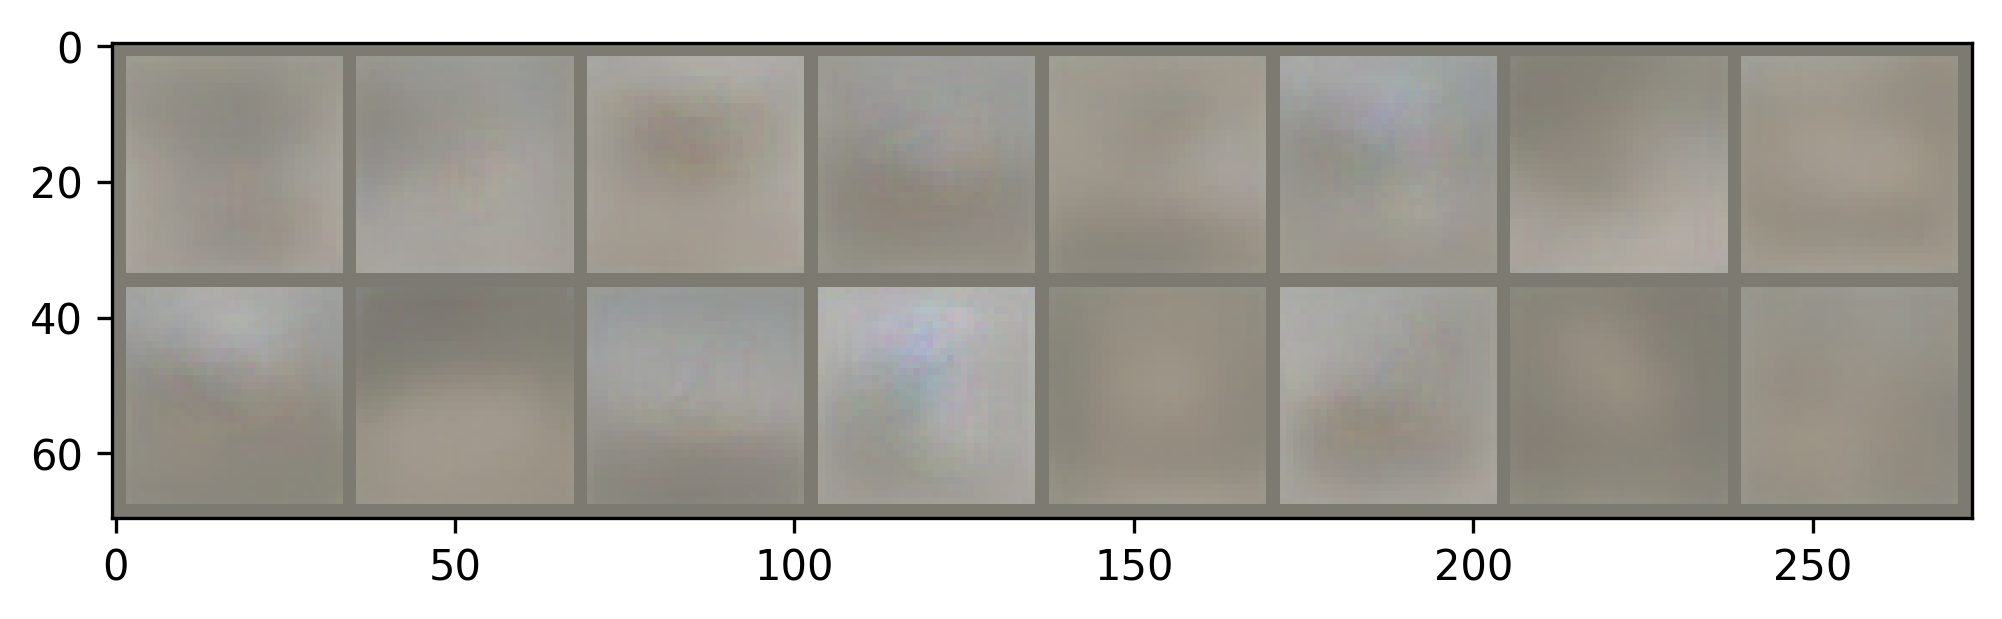

In [21]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);